## Pitch Names Classifier

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Classifier

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
pitchNames = ("C","D","E","F","G","A","B")

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 0
scalarEncoderParams.maximum = 6
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

print ("C: ", enc.encode(0))
print ("D: ", enc.encode(1))
print ("E: ", enc.encode(2))
print ("F: ", enc.encode(3))
print ("G: ", enc.encode(4))
print ("A: ", enc.encode(5))
print ("B: ", enc.encode(6))

C:  SDR( 21 ) 0, 1, 2
D:  SDR( 21 ) 3, 4, 5
E:  SDR( 21 ) 6, 7, 8
F:  SDR( 21 ) 9, 10, 11
G:  SDR( 21 ) 12, 13, 14
A:  SDR( 21 ) 15, 16, 17
B:  SDR( 21 ) 18, 19, 20


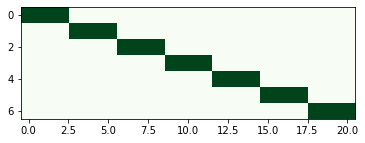

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
    sdrs.append( enc.encode( i ).dense )

    clear_output(wait = True)
    plt.cla
    plt.imshow(np.array(sdrs), cmap = "Greens")
    plt.show()

In [4]:
inputSDR  = SDR( dimensions = (21, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

print(sp)

Spatial Pooler Connections:
    Inputs (21) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 11 / 11 / 11
    Connected Synapses on Segment Min/Mean/Max 1 / 5.44097 / 10
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
clsr = Classifier()

In [6]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=8,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (4608) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



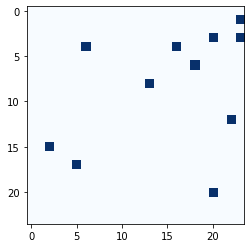

In [7]:
for i in range(len(pitchNames)):
    inputSDR = enc.encode(i)
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, True, activeSDR)
    print("Active SDR: ",activeSDR)
    clsr.learn( activeSDR.addNoise(0.2), i )
    print("Classifier learn: ",i)
    print("")

    clear_output(wait = True)
    plt.cla
    sampleSDR=activeSDR.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Blues")
    plt.pause(0.01)

In [8]:
#seq = ["C","C","G","G","A","A","G","F","F","E","E","D","D","C"]
seq=[0,0,4,4,5,5,4,3,3,2,2,1,1,0]

#seq_clsr = Classifier()

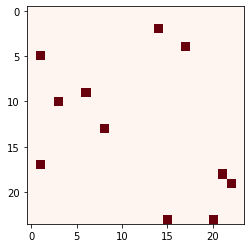

In [9]:
batch=10
for n in range(batch):    
    for i in range(len(seq)):
        inputSDR = enc.encode(seq[i])
        print("input SDR: ",inputSDR)
        sp.compute(inputSDR, True, activeSDR)
        print("Active SDR: ",activeSDR)
        #seq_clsr.learn( activeSDR, i )
        #print("Classifier learn: ",i)
        print("")

        #sampleSDR=activeSDR.dense.reshape(24,24)
        #plt.imshow(sampleSDR, cmap = "Blues")
        #plt.pause(0.01)

        tm.compute( activeSDR, learn=True)
        tm.activateDendrites(True)

        activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
        predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]

        print(tm.getActiveCells())
        print(tm.getPredictiveCells())

        active_sdr = SDR( tm.numberOfColumns() )
        active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
        print("-"*70 )
        print("Active sdr: ", active_sdr)

        predict_sdr = SDR( tm.numberOfColumns() )
        predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
        print("-"*70 )
        print("Predicted sdr: ",predict_sdr)

        if  len(predict_sdr.sparse) == 0:
            tm_predict = "nan"
            tm_pitchNames = "nan"      
        else:
            tm_predict = np.argmax( clsr.infer( predict_sdr) ) 
            tm_pitchNames = pitchNames[tm_predict]

        print("-"*70 )
        print("PDF: ",clsr.infer( predict_sdr) )
        print("-"*70 )

        print("predict index: ",tm_predict)
        print("-"*70 )
        print("predict label: ",tm_pitchNames)

        print("")

        
        clear_output(wait = True)
        plt.cla
        sampleSDR=predict_sdr.dense.reshape(24,24)
        plt.imshow(sampleSDR, cmap = "Reds")
        plt.pause(0.01)

---  0  ---
input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572



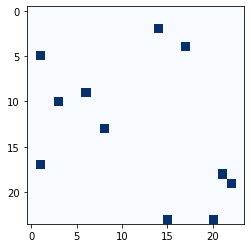

SDR( 576, 8 ) 496, 904, 968, 1776, 1944, 2560, 3272, 3624, 3824, 4536, 4576
SDR( 576, 8 ) 312, 480, 496, 552, 904, 968, 1688, 1776, 1944, 2560, 3056, 3272, 3624, 3824, 4072, 4184, 4320, 4416, 4448, 4536, 4576, 4584
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 39, 60, 62, 69, 113, 121, 211, 222, 243, 320, 382, 409, 453, 478, 509, 523, 540, 552, 556, 567, 572, 573
----------------------------------------------------------------------
PDF:  [0.14245725631691486, 0.14259952824328703, 0.14267066982064003, 0.14257579057675906, 0.14386474045032369, 0.14297555743420118, 0.14285646075383804]
----------------------------------------------------------------------
predict index:  4
----------------------------------------------------------------------
predict label:  G



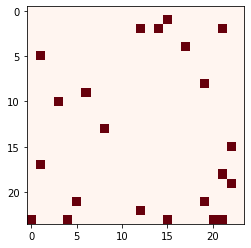

---  1  ---
input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572



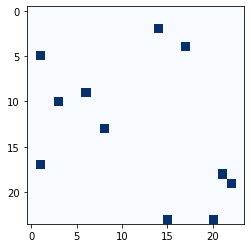

SDR( 576, 8 ) 496, 904, 968, 1776, 1944, 2560, 3272, 3624, 3824, 4536, 4576
SDR( 576, 8 ) 312, 480, 496, 552, 904, 968, 1688, 1776, 1944, 2560, 3056, 3272, 3624, 3824, 4072, 4184, 4320, 4416, 4448, 4536, 4576, 4584
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 39, 60, 62, 69, 113, 121, 211, 222, 243, 320, 382, 409, 453, 478, 509, 523, 540, 552, 556, 567, 572, 573
----------------------------------------------------------------------
PDF:  [0.14245725631691486, 0.14259952824328703, 0.14267066982064003, 0.14257579057675906, 0.14386474045032369, 0.14297555743420118, 0.14285646075383804]
----------------------------------------------------------------------
predict index:  4
----------------------------------------------------------------------
predict label:  G



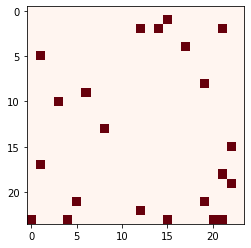

---  2  ---
input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573



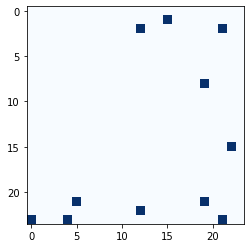

SDR( 576, 8 ) 312, 480, 552, 1688, 3056, 4072, 4184, 4320, 4416, 4448, 4584
SDR( 576, 8 ) 313, 481, 553, 1689, 3057, 4073, 4185, 4321, 4417, 4449, 4585
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
----------------------------------------------------------------------
PDF:  [0.14245725631691486, 0.14259952824328703, 0.14267066982064003, 0.14257579057675906, 0.14386474045032369, 0.14297555743420118, 0.14285646075383804]
----------------------------------------------------------------------
predict index:  4
----------------------------------------------------------------------
predict label:  G



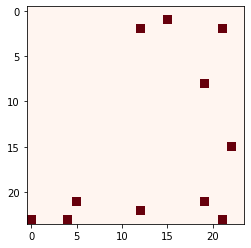

---  3  ---
input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573



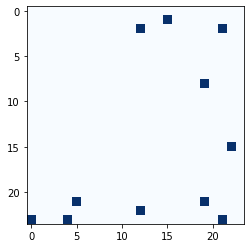

SDR( 576, 8 ) 313, 481, 553, 1689, 3057, 4073, 4185, 4321, 4417, 4449, 4585
SDR( 576, 8 ) 568, 960, 1352, 1648, 1744, 2168, 2496, 2504, 2688, 3368, 4585
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
----------------------------------------------------------------------
PDF:  [0.14248331279528362, 0.14248328435081425, 0.14276805776839507, 0.14272080472058354, 0.14275627518276213, 0.14393186209073844, 0.1428564109903732]
----------------------------------------------------------------------
predict index:  5
----------------------------------------------------------------------
predict label:  A



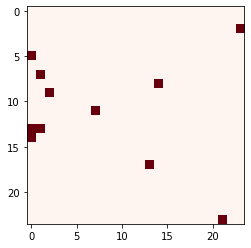

---  4  ---
input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573



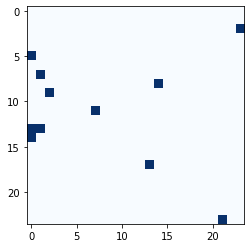

SDR( 576, 8 ) 568, 960, 1352, 1648, 1744, 2168, 2496, 2504, 2688, 3368, 4585
SDR( 576, 8 ) 569, 961, 1353, 1649, 1745, 2169, 2497, 2505, 2689, 3369, 4586
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
----------------------------------------------------------------------
PDF:  [0.14248331279528362, 0.14248328435081425, 0.14276805776839507, 0.14272080472058354, 0.14275627518276213, 0.14393186209073844, 0.1428564109903732]
----------------------------------------------------------------------
predict index:  5
----------------------------------------------------------------------
predict label:  A



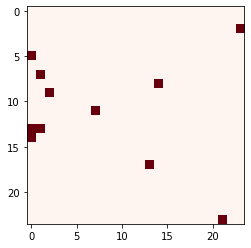

---  5  ---
input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573



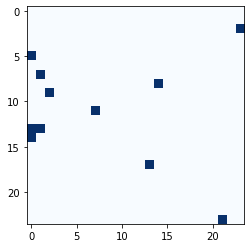

SDR( 576, 8 ) 569, 961, 1353, 1649, 1745, 2169, 2497, 2505, 2689, 3369, 4586
SDR( 576, 8 ) 314, 482, 554, 1690, 3058, 4074, 4186, 4322, 4418, 4450, 4586
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
----------------------------------------------------------------------
PDF:  [0.14245725631691486, 0.14259952824328703, 0.14267066982064003, 0.14257579057675906, 0.14386474045032369, 0.14297555743420118, 0.14285646075383804]
----------------------------------------------------------------------
predict index:  4
----------------------------------------------------------------------
predict label:  G



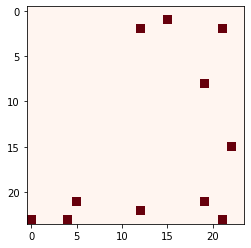

---  6  ---
input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573



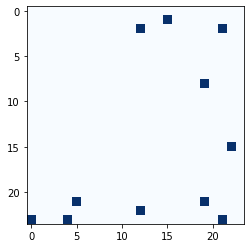

SDR( 576, 8 ) 314, 482, 554, 1690, 3058, 4074, 4186, 4322, 4418, 4450, 4586
SDR( 576, 8 ) 440, 1392, 2032, 2288, 2720, 2960, 3312, 4104, 4208, 4352, 4520
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565
----------------------------------------------------------------------
PDF:  [0.1425713237747531, 0.1425713237747531, 0.1425710385848425, 0.14371637309739516, 0.14285665652830803, 0.14285665652830803, 0.14285665652830803]
----------------------------------------------------------------------
predict index:  3
----------------------------------------------------------------------
predict label:  F



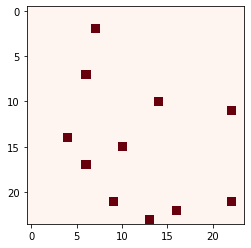

---  7  ---
input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565



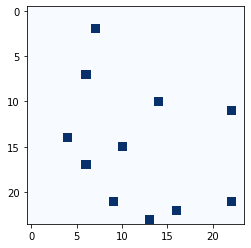

SDR( 576, 8 ) 440, 1392, 2032, 2288, 2720, 2960, 3312, 4104, 4208, 4352, 4520
SDR( 576, 8 ) 441, 1393, 2033, 2289, 2721, 2961, 3313, 4105, 4209, 4353, 4521
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565
----------------------------------------------------------------------
PDF:  [0.1425713237747531, 0.1425713237747531, 0.1425710385848425, 0.14371637309739516, 0.14285665652830803, 0.14285665652830803, 0.14285665652830803]
----------------------------------------------------------------------
predict index:  3
----------------------------------------------------------------------
predict label:  F



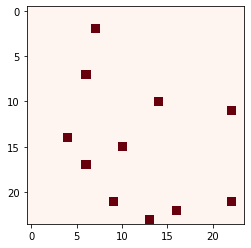

---  8  ---
input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565



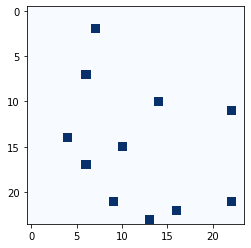

SDR( 576, 8 ) 441, 1393, 2033, 2289, 2721, 2961, 3313, 4105, 4209, 4353, 4521
SDR( 576, 8 ) 536, 824, 1464, 3520, 4280, 4336, 4360, 4368, 4376, 4464, 4568, 4587
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 55, 174, 254, 286, 340, 370, 414, 513, 526, 544, 565
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571, 573
----------------------------------------------------------------------
PDF:  [0.1423408882998925, 0.1423408598459438, 0.1436276116226518, 0.14291134054463092, 0.14294704901385155, 0.14297566035197526, 0.142856563585883]
----------------------------------------------------------------------
predict index:  2
----------------------------------------------------------------------
predict label:  E



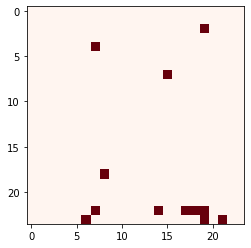

---  9  ---
input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571



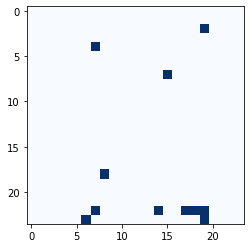

SDR( 576, 8 ) 536, 824, 1464, 3520, 4280, 4336, 4360, 4368, 4376, 4464, 4568
SDR( 576, 8 ) 537, 825, 1465, 3521, 4281, 4337, 4361, 4369, 4377, 4465, 4569, 4588
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571, 573
----------------------------------------------------------------------
PDF:  [0.1423408882998925, 0.1423408598459438, 0.1436276116226518, 0.14291134054463092, 0.14294704901385155, 0.14297566035197526, 0.142856563585883]
----------------------------------------------------------------------
predict index:  2
----------------------------------------------------------------------
predict label:  E



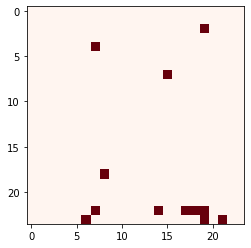

---  10  ---
input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571



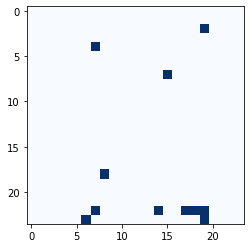

SDR( 576, 8 ) 537, 825, 1465, 3521, 4281, 4337, 4361, 4369, 4377, 4465, 4569
SDR( 576, 8 ) 792, 1216, 2376, 2976, 3880, 4210, 4296, 4419, 4440, 4512, 4600
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
----------------------------------------------------------------------
PDF:  [0.14218689244233682, 0.14347232173453606, 0.1428281324481573, 0.1428281514982586, 0.142971051094434, 0.14285671998345864, 0.14285671998345864]
----------------------------------------------------------------------
predict index:  1
----------------------------------------------------------------------
predict label:  D



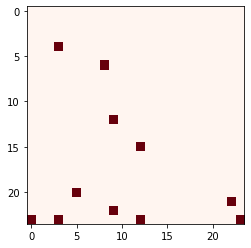

---  11  ---
input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575



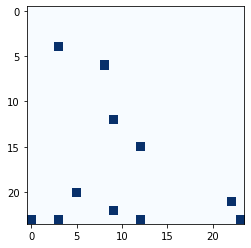

SDR( 576, 8 ) 792, 1216, 2376, 2976, 3880, 4210, 4296, 4419, 4440, 4512, 4600
SDR( 576, 8 ) 793, 1217, 2377, 2977, 3881, 4211, 4297, 4420, 4441, 4513, 4601
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
----------------------------------------------------------------------
PDF:  [0.14218689244233682, 0.14347232173453606, 0.1428281324481573, 0.1428281514982586, 0.142971051094434, 0.14285671998345864, 0.14285671998345864]
----------------------------------------------------------------------
predict index:  1
----------------------------------------------------------------------
predict label:  D



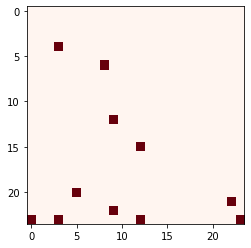

---  12  ---
input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575



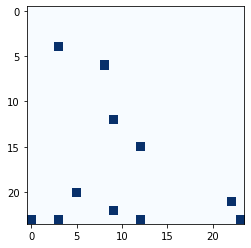

SDR( 576, 8 ) 793, 1217, 2377, 2977, 3881, 4211, 4297, 4420, 4441, 4513, 4601
SDR( 576, 8 ) 497, 905, 969, 1777, 1945, 2561, 3273, 3625, 3825, 4537, 4577
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
----------------------------------------------------------------------
PDF:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
----------------------------------------------------------------------
predict index:  0
----------------------------------------------------------------------
predict label:  C



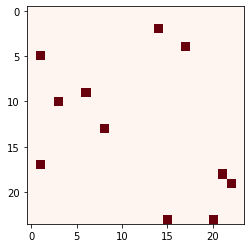

---  13  ---
input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572



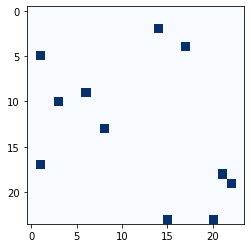

SDR( 576, 8 ) 497, 905, 969, 1777, 1945, 2561, 3273, 3625, 3825, 4537, 4577
SDR( 576, 8 ) 496, 904, 968, 1776, 1944, 2560, 3272, 3624, 3824, 4536, 4576
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
----------------------------------------------------------------------
PDF:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
----------------------------------------------------------------------
predict index:  0
----------------------------------------------------------------------
predict label:  C



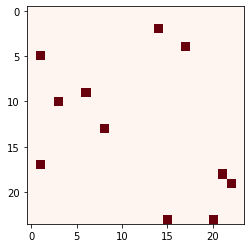

In [10]:
for i in range(len(seq)):
    print("--- ", i ," ---")
    inputSDR = enc.encode(seq[i])
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, True, activeSDR)
    print("Active SDR: ",activeSDR)
    print("")

    sampleSDR=activeSDR.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Blues")
    plt.pause(0.01)

    #tm.reset()
    tm.compute( activeSDR, learn=False)
    tm.activateDendrites(True)
    activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
    predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]

    print(tm.getActiveCells())
    print(tm.getPredictiveCells())

    active_sdr = SDR( tm.numberOfColumns() )
    active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
    print("-"*70 )
    print("Active sdr: ", active_sdr)

    predict_sdr = SDR( tm.numberOfColumns() )
    predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
    print("-"*70 )
    print("Predicted sdr: ",predict_sdr)

    if  len(predict_sdr.sparse) == 0:
        tm_predict = "nan"
        tm_pitchNames = "nan"      
    else:
        tm_predict = np.argmax( clsr.infer( predict_sdr) ) 
        tm_pitchNames = pitchNames[tm_predict]

    print("-"*70 )
    print("PDF: ",clsr.infer( predict_sdr) )
    print("-"*70 )

    print("predict index: ",tm_predict)
    print("-"*70 )
    print("predict label: ",tm_pitchNames)

    print("")

    sampleSDR=predict_sdr.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Reds")
    plt.pause(0.01)

In [ ]:
["C","C","G","G","A","A","G","F","F","E","E","D","D","C"]

In [ ]:
["C","G","G","G","A","A","G","F","F","E","E","D","D","C"]